In [2]:
import sys
import subprocess
import pkg_resources
import numpy as np

required = { 'scikit-image'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

###### 1. Opis danych dla pierwszych 6 zajęć laboratoryjnych

Dane są dostępne w postaci spakowanej w pliku <a href="http://fraktal.faculty.wmi.amu.edu.pl/symulowanie_wizualne/train_test_sw.zip">train_test_sw.zip</a>. Po rozpakowaniu otrzymujmemy katalog <i>train_test_sw</i> zawierający:

<ol>
        <li>katalog <i>train_sw</i> - katalog z listą podkatalogów przechowujących obrazy treningowe (format 4-bajtowy rgba) podzielone na kategorie - nazwa katalogu odpowiada nazwie kategorii
     <li>katalog <i>test_sw</i> - katalog z listą plików zawierających obrazy testowe   
     <li>plik <i>test_labels.json</i> - zawiera etykiety obrazów testowych  w formacie JSON - pojedyncza dana to słownik  
         <p>
             <code>
                 {
                    "filename": nazwa pliku,
                    "value": nazwa_kategorii
                 }
            </code>
 </ol>

#### 2. Funkcja <code>load_train_data(input_dir, newSize=(64,64))</code>

Funkcja ta wczytuje dane teningowe, przeskalowuje je do rozmiaru podanego w drugim parametrze (z interpolacją typu cv2.INTER_AREA), przeprowadza ich normalizację  i zwraca słownik w formacie:
<p>
<code>
{  "data" - lista (typ <code>list</code>) obrazów, gdzie pojedynczy obraz jest tablicą <code>numpy.array</code> zapisaną wierszowo blokami rgb
   "categories_name" - lista nazw kategorii klasyfikacyjnych, gdzie pojedyncza nazwa kategorii jest typu <code>str</code>
   "categories_count" - lista ilości przykładów z pozszczególnych kategorii w danych treningowych 
   "labels" - lista etykiet wszystkich danych treningowych
 }
 </code>
 
 Parametry:
    
 - <code>input_dir</code> przyjmuje wartość  ścieżki katalogu 'train_sw'
 - <code>newSize</code> przyjmuje wartość  krotki określającej rozmiar przeskalowanych obrazów   

In [2]:


def load_train_data(input_dir, newSize=(64,64)):
    '''
    '''

    
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json


    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib
    
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255#normalizacja
                train_img.append(img)
        categories_count.append(count)
    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X
    


In [3]:
data = load_train_data('./train_test_sw/train_sw')
print(data['categories_name'])
print(data['categories_count'])
print([data["labels"][50],data["labels"][200],data["labels"][300]])
print(list(data["values"][100][1][10]))

['Beech', 'Lemon', 'Tomato', 'Mean', 'Gardenia']
[203, 206, 206, 206, 206]
['Beech', 'Beech', 'Lemon']
[0.06666666666666667, 0.058823529411764705, 0.047058823529411764, 1.0]


#### 3. Funkcja <code>load_test_data(input_dir, newSize=(64,64))</code>

Funkcja ta  wczytuje dane testowe, przeskalowuje je do rozmiaru podanego w drugim parametrze (z 
interpolacją typu cv2.INTER_AREA), przeprowadza ich normalizację  i zwraca słownik w formacie:
<p>
    
<code>
{  "data" - lista (typ <code>list</code>) obrazów, gdzie pojedynczy obraz jest tablicą <code>numpy.array</code> zapisaną wierszowo blokami rgb
   "categories_name" - lista nazw kategorii klasyfikacyjnych, gdzie pojedyncza nazwa kategorii jest typu <code>str</code>
   "categories_count" - lista ilości przykładów z pozszczególnych kategorii w danych testowych 
   "labels" - lista etykiet wszystkich danych testowych
 }
 </code>
 
 Parametry:
    
 - <code>input_dir</code> przyjmuje wartość  ścieżki katalogu 'test_sw'
 - <code>newSize</code> przyjmuje wartość  krotki określającej rozmiar przeskalowanych obrazów   


In [4]:
def load_test_data(input_dir, newSize=(64,64)):
    '''
    '''

    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json


    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib



    image_path = Path(input_dir)

    labels_path = image_path.parents[0] / 'test_labels.json'

    #with labels_path.open("r", encoding ="utf-8") as f:
    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    #print(objects)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in  objects:
        if e['value'] != c:
            #print(count)
            #print(c)
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)



    test_img = []

    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)#zwraca ndarry postaci xSize x ySize x colorDepth
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
        img = img / 255#normalizacja
        test_img.append(img)
        labels.append(e['value'])


    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X



In [5]:
data = load_test_data('./train_test_sw/test_sw')
print(data['categories_name'])
print(data['categories_count'])
print([data["labels"][10],data["labels"][20],data["labels"][30]])
print(list(data["values"][10][1][10]))

['Beech', 'Gardenia', 'Lemon', 'Mean', 'Tomato']
[51, 52, 52, 52, 52]
['Beech', 'Beech', 'Beech']
[0.058823529411764705, 0.00784313725490196, 0.0, 1.0]


#### 4.  Zadanie 1 (4pkt): 

Napisz kod klasy <code>KNearestNeighbor</code> implementującej klasyfikator <i>knn</i>. Należy zimplementować następujące  metody:

    
 - <code>konstruktor</code> pobierający listę obrazów treningowych (zgodną zw składową 'values' wczytanego słownika) oraz listę ich etykiet
 - metoda <code>l_p_metric(image1, image2, p):</code> zwracająca wartość odległości pomiędzy dwoma obrazami, mierzoną normą typu <i>l_p</i> - parametr <code>p</code> określa 'potęgę' normy
 - metoda <code>predict(test_images, k,p):</code> zwracająca listę prognozowanych etykiet dla obrazów testowych (parametr <code>test_images</code>). Paramter drugi określa liczbę przeszukiwanych sąsiadów, natomiast paramter trzeci określa potęgę wybranej metryki.
 - metoda <code>accuracy(test_images, k,p)</code> zwracająca dokładność klasyfikatora na zbiorze testowym. Parametr drugi i trzeci są jak w metodzie <code>predict()</code>


In [6]:
import numpy as np
from tqdm.notebook import tqdm

class KNearestNeighbor(object):
    # BEGIN SOLUTION 
    def __init__(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train

    def predict(self, test_images, K, P):
        results = []

        for i in tqdm(range(len(test_images))):
            distances = [self._l_p_metric(test_images[i], x_train, P) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:K]
            k_labels = [self.Y_train[i] for i in k_indices]
            results.append(max(set(k_labels), key=k_labels.count))
        
        return np.array(results)

    def accuracy(self, y_true, y_pred):
        return np.sum(y_pred == y_true) / len(y_true)
    
    def _l_p_metric(self, image1, image2, p):
        #NOTE: L1 is manhattan distance, L2 is euclidean distance
        if p == 1:
            return np.sum(np.abs(image1 - image2))
        elif p == 2:
            return np.sqrt(np.sum(np.power(image1 - image2, 2)))
        else:
            ValueError("p must be 1 or 2")
    # END SOLUTION


In [9]:
from sklearn.preprocessing import LabelEncoder

data_train = load_train_data("./train_test_sw/train_sw",newSize=(256,256))
X_train = data_train['values']
y_train = data_train['labels']


data_test = load_test_data("./train_test_sw/test_sw",newSize=(256,256))
X_test = data_test['values']
y_test = data_test['labels']



class_le = LabelEncoder()
y_train_enc = class_le.fit_transform(y_train)

Knn  = KNearestNeighbor(X_train, y_train_enc)

y_test_enc = class_le.fit_transform(y_test)

# pred = Knn.predict(X_test, K=1,P=1)
# print(Knn.accuracy(y_test_enc,pred))

# pred = Knn.predict(X_test, K=1,P=2)
# print(Knn.accuracy(y_test_enc,pred))

# pred = Knn.predict(X_test, K=5,P=1)
# print(Knn.accuracy(y_test_enc,pred))
      
pred = Knn.predict(X_test, K=5,P=2)
print(Knn.accuracy(y_test_enc,pred))

# pred = Knn.predict(X_test, K=10,P=1)
# print(Knn.accuracy(y_test_enc,pred))
      
# pred = Knn.predict(X_test, K=10,P=2)
# print(Knn.accuracy(y_test_enc,pred))


  0%|          | 0/259 [00:00<?, ?it/s]

0.4826254826254826


####  5. Zadanie 2 (2pkt): 

Napisz kod funkcji  <code>crossValidation(X,y, n = 10,  k=1,p=1  ):</code> obliczającą algorytm <code>knn </code> z n-krotną walidacją krzyżową.

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

def crossValidation(X, y, n=10, k=1, p=1):
        # BEGIN SOLUTION 
        kf = KFold(n_splits=n, shuffle=True, random_state=42)
        results = []

        for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                knn  = KNearestNeighbor(X_train, y_train)
                pred = knn.predict(X_test, K=k,P=p)
                evaluation_result = knn.accuracy(y_test,pred)
                results.append(evaluation_result)
        
        return np.mean(results)
        #END SOLUTION 


In [ ]:
res = crossValidation(X_train, y_train_enc, n=len(X_train), k=5, p=1)
print(res)

#### 6.  Zadanie 3 (4pkt): 

Napisz kod klasy <code>LogisticRegression</code> implementującej klasyfikator <i>wieloklasowej regresji logistycznej</i> z funkcją <code>softmax()</code> (ze standardowymi nazwami dwóch kluczowych funkcji: <i>fit()</i>, <i>predict()</i>).  Zastosuj ten kod do pobranych danych (zbiór walidacyjny losujemy ze zbioru treningowego) - oblicz następujące charakterystyki modelu dla danych walidacyjnych oraz treningowych: dokładność (accuracy), precyzję (precision), czułość(recall) oraz F1 - dla poszczególnych klas oraz globalnie (zob. np. <a href="https://medium.com/synthesio-engineering/precision-accuracy-and-f1-score-for-multi-label-classification-34ac6bdfb404">tu</a>).


(256, 256, 4)


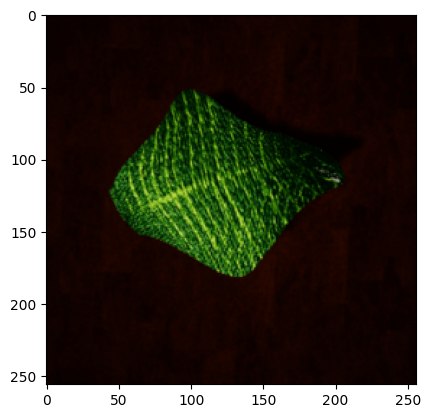

In [40]:
# BEGIN SOLUTION (zad. 3)
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegressionSoftmax:
    def __init__(self, num_classes, learning_rate=0.01, num_iterations=1000):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = np.zeros((num_features, self.num_classes))
        self.bias = np.zeros((1, self.num_classes))
        
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.initialize_parameters(num_features)
        
        for i in tqdm(range(self.num_iterations)):
            # Forward pass
            Z = np.dot(X, self.weights) + self.bias
            A = self.softmax(Z)
            
            # Compute gradients
            dZ = A - np.eye(self.num_classes)[y]
            dW = 1 / num_samples * np.dot(X.T, dZ)
            db = 1 / num_samples * np.sum(dZ, axis=0, keepdims=True)
            
            # Update parameters
            self.weights -= self.learning_rate * dW
            self.bias -= self.learning_rate * db
            
            # Print loss every 100 iterations
            if i % 10 == 0:
                loss = -1 / num_samples * np.sum(np.log(A[np.arange(num_samples), y]))
                print(f'Iteration {i}: Loss {loss}')
                
    def predict(self, X):
        Z = np.dot(X, self.weights) + self.bias
        A = self.softmax(Z)
        return np.argmax(A, axis=1)
    
    def _softmax(X):
        return np.exp(X) / np.sum(np.exp(X))
        


print(X_train[0].shape)

plt.imshow(X_train[0])
plt.show()
#END SOLUTION 

#### 7.  Zadanie 4 (1pkt): 

Oblicz ile danych z poszczególnych klas znajduje się po dodatniej/ujemnej stronie hiperpłaszczyzny klasyfikacyjnej dla danej klasy 

In [ ]:
# BEGIN SOLUTION (zad. 4)
        
#END SOLUTION 

#### 8. Dwa uzupełnienia

W pliku [lab1_add](lab1_add.ipynb) znajdują się  minimalne podstawy teoretyczne związane z konstrukcją funkcji kosztu oraz algorytmami optymalizacji.